# Calculate Customer Lifetime Value

In [247]:
#Import necessary libraries
import pandas as pd
import matplotlib as plt

#Import Data
tx_data=pd.read_csv("OnlineRetail.csv", encoding="cp1252")
tx_data=tx_data.head(1)

In [248]:
lf_tx_data

,frequency,recency,T,monetary_value
CustomerID,,,,
17850.0,6.0,365.0,373.0,599.701667


In [249]:
lf_tx_data.iat[0,0] = 6.0
lf_tx_data.iat[0,1] = 365.0
lf_tx_data.iat[0,2] = 373.0
lf_tx_data.iat[0,3] = 599.701667

In [250]:
import pandas as pd

data = {'CustomerID': [1],
        'frequency': [6.0],
        'recency': [365],
       'T':[375],
       'monetary_value':[599.701667]}

df = pd.DataFrame(data)

In [251]:
df

,CustomerID,frequency,recency,T,monetary_value
0,1,6.0,365,375,599.701667


In [252]:
#Check the shape (number of columns and rows) in the dataset
tx_data.shape

(1, 8)

In [253]:
#Find out missing values
tx_data.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [254]:
#Remove time from date
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'], format="%m/%d/%Y %H:%M").dt.date

#There are 135,080 missing values in the CustomerID column, and since our analysis is based on customers, 
#we will remove these missing values.
tx_data = tx_data[pd.notnull(tx_data['CustomerID'])]

#Keep records with non negative quantity
tx_data = tx_data[(tx_data['Quantity']>0)]

#Add a new column depicting total sales
tx_data['Total_Sales'] = tx_data['Quantity'] * tx_data['UnitPrice']
necessary_cols = ['CustomerID', 'InvoiceDate', 'Total_Sales']
tx_data = tx_data[necessary_cols]
tx_data.head()

,CustomerID,InvoiceDate,Total_Sales
0,17850.0,2010-12-01,15.3


In [255]:
#Print records pertaining unique Customer IDs
print(tx_data['CustomerID'].nunique())

1


In [256]:
#Check the Last order date
last_order_date = tx_data['InvoiceDate'].max()
print(last_order_date)
print("--------------------------------------")
print(tx_data[(tx_data['CustomerID']==12346)])

2010-12-01
--------------------------------------
Empty DataFrame
Columns: [CustomerID, InvoiceDate, Total_Sales]
Index: []


In [257]:
from lifetimes.plotting import *
from lifetimes.utils import *
#Built-in utility functions from lifetimes package to transform the transactional data (one row per purchase) 
#into summary data (a frequency, recency, age and monetary).

lf_tx_data = summary_data_from_transaction_data(tx_data, 'CustomerID', 'InvoiceDate', monetary_value_col='Total_Sales', observation_period_end='2011-12-9')
lf_tx_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value
0,17850.0,0.0,0.0,373.0,0.0


In [258]:
aaa=lf_tx_data
aaa

,frequency,recency,T,monetary_value
CustomerID,,,,
17850.0,0.0,0.0,373.0,0.0


In [259]:
lf_tx_data


,frequency,recency,T,monetary_value
CustomerID,,,,
17850.0,0.0,0.0,373.0,0.0


In [260]:
lf_tx_data.iat[0,0] = 6.0
lf_tx_data.iat[0,1] = 365.0
lf_tx_data.iat[0,2] = 373.0
lf_tx_data.iat[0,3] = 599.701667

count    1.0
mean     6.0
std      NaN
min      6.0
25%      6.0
50%      6.0
75%      6.0
max      6.0
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 0.0 %


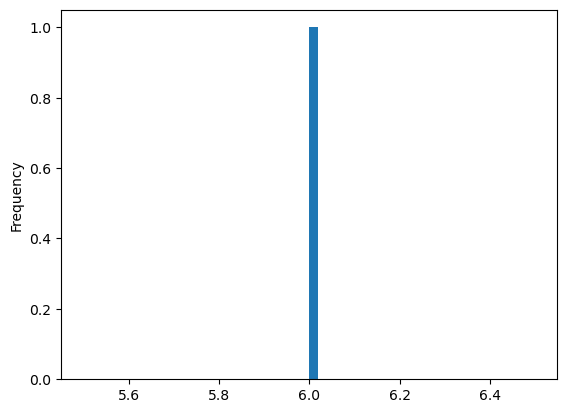

In [261]:
%matplotlib inline
#Create histogram to find out how many customers purchased item only once.
lf_tx_data['frequency'].plot(kind='hist', bins=50)
print(lf_tx_data['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(lf_tx_data['frequency'] == 0)/float(len(lf_tx_data))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

In [262]:
#Frequency/Recency Analysis Using the BG/NBD Model
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 1 subjects, a: 0.00, alpha: 244.20, b: 0.00, r: 3.94>


In [263]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,3.942355e+00,4.464243e+00,-4.807561e+00,1.269227e+01
alpha,2.442012e+02,3.171916e+02,-3.774944e+02,8.658969e+02
a,1.894834e-18,1.395709e-11,-2.735589e-11,2.735590e-11
b,6.821999e-07,5.008299e+00,-9.816266e+00,9.816267e+00


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

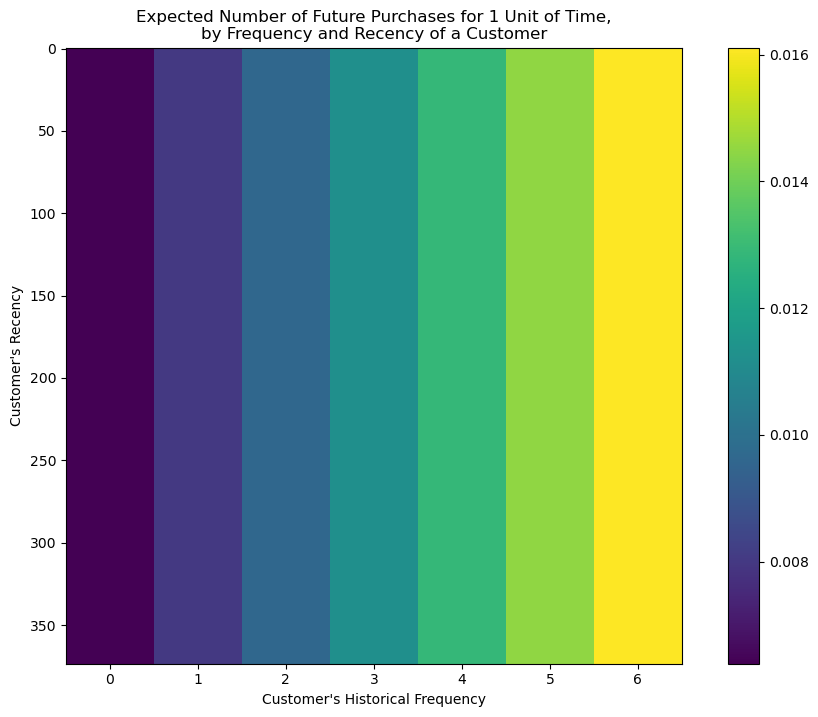

In [264]:
#Visualizing our frequency/recency matrix
%matplotlib inline
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

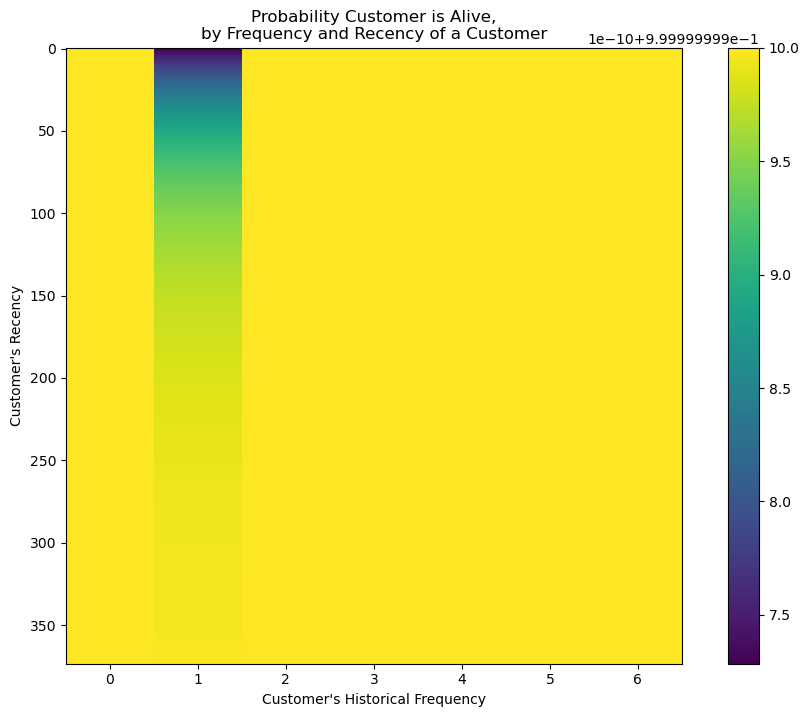

In [265]:
#predict if the customers are surely alive:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [266]:
#Predict future transaction in next 10 days i.e.top 10 customers that the model expects them to make purchases 
#in the next 10 days, based on historical data

t = 10
lf_tx_data['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T']),2)
lf_tx_data.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn
0,17850.0,6.0,365.0,373.0,599.701667,0.16


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

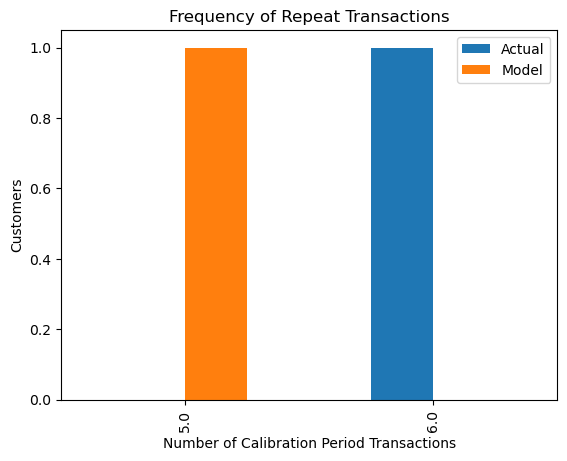

In [267]:
#Assessing model fit
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [268]:
# #Customer's future transaction prediction for next 10 days

# t = 10
# individual = lf_tx_data.loc[14911]
# bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

# #OBSERVATION: Our model predicts that customer 14911’s future transaction is appx 3 in 10 days.

In [269]:
#Check if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation.
lf_tx_data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,NaN,NaN
frequency,NaN,NaN


In [270]:
#Shortlist customers who had at least one repeat purchase with the company. 
shortlisted_customers = lf_tx_data[lf_tx_data['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

   CustomerID  frequency  recency      T  monetary_value  pred_num_txn
0     17850.0        6.0    365.0  373.0      599.701667          0.16
-----------------------------------------
The Number of Returning Customers are:  1


In [271]:
#Train gamma-gamma model by taking into account the monetary_value.
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(shortlisted_customers['frequency'],
        shortlisted_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1 subjects, p: 3.58, q: 0.27, v: 3.54>


In [272]:
#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. 
print(ggf.conditional_expected_average_profit(
        lf_tx_data['frequency'],
        lf_tx_data['monetary_value']
    ).head(10))

CustomerID
17850.0    621.367985
dtype: float64


In [273]:
lf_tx_data['pred_txn_value'] = round(ggf.conditional_expected_average_profit(
        lf_tx_data['frequency'],
        lf_tx_data['monetary_value']), 2)
lf_tx_data.reset_index()

a=lf_tx_data.reset_index()
a

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,17850.0,6.0,365.0,373.0,599.701667,0.16,621.37


In [274]:
#Calculate Customer Lifetime Value
lf_tx_data['CLV'] = round(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    lf_tx_data['frequency'],
    lf_tx_data['recency'],
    lf_tx_data['T'],
    lf_tx_data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
), 2)

lf_tx_data.drop(lf_tx_data.iloc[:, 0:6], inplace=True, axis=1)


lf_tx_data.sort_values(by='CLV', ascending=False).reset_index()

b=lf_tx_data.sort_values(by='CLV', ascending=False).reset_index()
b

,CustomerID,CLV
0,17850.0,3379.72


In [275]:
lf_tx_data

,CLV
CustomerID,
17850.0,3379.72


In [276]:
b

,CustomerID,CLV
0,17850.0,3379.72


In [277]:
lf_tx_data

,CLV
CustomerID,
17850.0,3379.72


In [278]:
# c=pd.concat([df1, lf_tx_data]).sort_values('CustomerID').drop_duplicates(['CustomerID'], keep='last')

In [279]:
a

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,17850.0,6.0,365.0,373.0,599.701667,0.16,621.37


In [280]:
b

,CustomerID,CLV
0,17850.0,3379.72


In [281]:
merged_df = pd.merge(a, b, on='CustomerID')

In [282]:
merged_df

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value,CLV
0,17850.0,6.0,365.0,373.0,599.701667,0.16,621.37,3379.72


In [283]:
d.to_csv('online_retail1.csv')

NameError: name 'd' is not defined

In [ ]:
bgf

In [ ]:
ggf

In [ ]:
import lifetimes

# Define the customer transaction history
transaction_data = [1, 1, 0, 1, 1, 1, 1, 0, 0, 1]
recency=10
T=2
# Fit the BG/NBD model to the transaction data
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(transaction_data, transaction_data, transaction_data)

# Calculate the expected transactions for the customer
expected_transactions = bgf.conditional_expected_number_of_purchases_up_to_time(12, transaction_data[0],recency,T)

# Calculate the expected average transaction value
expected_value = 100

# Calculate the Customer Lifetime Value (CLV)
CLV = expected_transactions * expected_value

print("CLV: ", CLV)


In [ ]:
print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

In [ ]:
import pandas as pd

# Define the data for each column
data = {
    'Name': ['John', 'Jane', 'Jim', 'Jack'],
    'Age': [30, 32, 28, 35],
    'City': ['New York', 'Los Angeles', 'Chicago', 'Houston']
}

# Create the dataframe
df = pd.DataFrame(data)

print(df)

In [ ]:
merged_df

In [ ]:
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0])

print(data.head())

c=data.head(1)

In [ ]:
first_row = data.iloc[0]

print(first_row)

In [ ]:
first_row

In [ ]:
data = c

In [ ]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

In [ ]:
bgf.summary

In [ ]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases')

In [ ]:
aaa

In [284]:
df = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})
value = df.loc[0, 'col1']
value

1